<a href="https://colab.research.google.com/github/gurmu/Deep-Chatbot/blob/master/Smart_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Import modules:

In [0]:
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import time

## Data Preparation:
# Load up the data

In [0]:
def load_dataset(path):
    """
    Reads the data from the csv file.
    Arguments:
        path: a string.
    Returns:
        dataset: a Pandas Dataframe with two columns, namely: `Question` and `Answer`.
        X: a NumPy array representing `Question` column.
        Y: a NumPy array representing `Answer` column.
    """
    
    # read the csv file into a pandas dataframe
    dataset = pd.read_csv(path, usecols=['Question', 'Answer'])
    # make sure all cell values are strings; because some of them 
    # only contain numbers, so they maybe mistaken with other types.
    dataset = dataset.applymap(str)
    # shuffle the rows of the dataframe and then reset the index
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    
    X = np.asarray(dataset['Question'])
    Y = np.asarray(dataset['Answer'])
    
    X = np.apply_along_axis(lambda sen: '<start> '+ sen + ' <end>', 0, X)
    Y = np.apply_along_axis(lambda sen: '<start> '+ sen + ' <end>', 0, Y)
    
    return dataset, X, Y

In [4]:
os

<module 'os' from '/usr/lib/python3.6/os.py'>

In [5]:
os.getcwd

<function posix.getcwd>

In [6]:
os.getcwd() 


'/content'

In [0]:
!mkdir path

In [8]:
cd path/

/content/path


In [12]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [13]:
files_path = '/content/path/'
qa_dataframe, X, Y = load_dataset(files_path + 'dataset.csv')
qa_dataframe.head()

,Question,Answer
0,i met a girl yesterday . . .,she was a dwarf and she was just shy of waist ...
1,i finally got my shit together .,no more diarrhea !
2,the most offensive joke i know .,why do pharmacists put cotton wool balls in al...
3,what is a dog ' s favourite easter treat ?,jelly bones !
4,"i used to work in children ' s wear ,",but i grew out of it .


In [14]:
print(f"Number of question-answer pairs in the dataset: {len(qa_dataframe)}")

Number of question-answer pairs in the dataset: 176980


Cache all hyperparameters into this dictionary:

In [0]:
hyperparameters = dict()


**Choose the size of vocabulary**:

This is a hyperparameter that you can play with.

In [0]:
VOCAB_SIZE = 10000


Now, let's tokenize the data, by converting each sentence (question or answer) to a sequence of integers which represent indices of their embeddings.

In [0]:
def tokenize(sentences, vocab_size):
  
    """
    Using Tensorflow Tokenizer to turn each sentence into a sequence of integers 
    (each integer being the index of a token in a dictionary).
    Arguments:
      X: a list or a NumPy array of strings, where each element is a sentence.
    Returns:
      tensor: a NumPy ndarray, where each row represents the the sequence of
              integers that maps the words of the equivalent sentence in 
              the `sentences` list to a their indices (for embbedings). shape=(batch_size, )
      lang_tokenizer: a Tensorflow Tokenizer which have been fit on `sentences`.
    """ 

    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, 
                                                           filters='')
    lang_tokenizer.fit_on_texts(sentences)

    tensor = lang_tokenizer.texts_to_sequences(sentences)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [20]:
# all sentences (Questions & Answers)
# we need to fit the tokenizer on all sentences; to create word_index and 
# index_word mapper dictionaries for the most frequent VOCAB_SIZE= 10,000 words.
texts = np.concatenate((X, Y))
# tokenize the data
tensor, text_tokenizer = tokenize(texts, VOCAB_SIZE)

print(f"texts[0]= {texts[0]}")
print(f"tensor[0]= {tensor[0]}")

texts[0]= <start> i met a girl yesterday . . . <end>
tensor[0]= [  1   9 589   5 120 484   3   3   3   2   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [0]:
import tensorflow as tf


As we see, each sentence has been converted to an array with indices that will be used to map words to their embedding vectors.

Now, let's extract back X (for questions) and Y (for answers) arrays from tensor:

In [21]:
# extract questions and answers back from tensor
X, Y = tensor[:len(X)], tensor[len(X):]

print(f"Shape of X (questions): {X.shape}")
print(f"Shape of Y (answers): {Y.shape}")

Shape of X (questions): (176980, 32)
Shape of Y (answers): (176980, 32)


Get the maximum sequence length for both input and target tensors:

In [0]:
def max_seq_length(tensor):
    """
    Get maximum sequence length in the corpus. And, make sure that all rows in
    `tensor` has the same length.
    Arguments:
      tensor: a NumPy ndarray of shape (batch_size,) where each row represents
      indices mapping to words in equivalent sentences.
    Returns:
      max_len: an integer representing maximum sequence length.
    """
    batch_size = len(tensor)
    lengths = [len(sentence) for sentence in tensor]
    max_len = max(lengths)

    # check if all rows in `tensor` has the same length (equal to max_len)
    assert lengths == [max_len]*batch_size

    return max_len

In [24]:
# Get max_seq_length of input and target tensors
max_length_inp, max_length_targ = max_seq_length(X), max_seq_length(Y)
print(f"Maximum sequence length for input (questions) tensor: {max_length_inp}")
print(f"Maximum sequence length for target (answers) tensor: {max_length_targ}")

Maximum sequence length for input (questions) tensor: 32
Maximum sequence length for target (answers) tensor: 32


Save the arrays as npy files:

In [0]:
data_arrays_path = os.path.join(files_path, 'data_arrays')
# create the folder if it does not exist
if not os.path.exists(data_arrays_path):
    os.makedirs(data_arrays_path)
    
np.save(os.path.join(data_arrays_path, 'X.npy'), X)
np.save(os.path.join(data_arrays_path, 'Y.npy'), Y)

In [0]:
def read_glove_vectors(glove_file):
    """
    This function reads GloVe vectors from .txt file and 
    returns a word to vector dictionary.
    Arguments:
      glove_file: a string path to GloVe word embeddings file.
    Returns:
      word_to_vec: a Python dictionary that maps words to their embeddings.
    """

    import numpy as np
    
    # open the file
    with open(glove_file, 'r', encoding="utf-8") as f:
        
        words = set()
        word_to_vec = {}

        # loop over the rows in the file
        for line in f:
            # read the line, strip it (remove leading and trailing spaces) and split it
            line = line.strip().split()
            # first item in the list 'line' is the word itself
            curr_word = line[0]
            # add the word to set of words
            words.add(curr_word)
            # add the words with its vector representation as a (key, value) pair to the dictionary
            word_to_vec[curr_word] = np.array(line[1:], dtype=np.float64)

    return word_to_vec

## Download GloVe Vectors

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-18 19:24:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-18 19:24:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-18 19:24:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [29]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [30]:
!ls
!pwd

data_arrays  glove.6B.100d.txt	glove.6B.300d.txt  glove.6B.zip
dataset.csv  glove.6B.200d.txt	glove.6B.50d.txt
/content/path


In [0]:
glove_file = "/content/path/glove.6B.200d.txt"
word_to_vec = read_glove_vectors(glove_file)

# The Model
**Choosing Hyperparameters:**

In [0]:
BUFFER_SIZE = X.shape[0]
BATCH_SIZE = 128
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE 
embedding_dim = 200
units = 512 
vocab_size = VOCAB_SIZE + 1

In [33]:
print(f"Buffer size: {BUFFER_SIZE}, Batch size: {BATCH_SIZE}, Steps per epoch: {steps_per_epoch}")
print(f"Embedding size: {embedding_dim}, # of units: {units}")
print(f"Vocab size: {vocab_size}")

Buffer size: 176980, Batch size: 128, Steps per epoch: 1382
Embedding size: 200, # of units: 512
Vocab size: 10001


In [0]:
# cache these values into the hyperparameters dictionary
hyperparameters['buffer_size'] = BUFFER_SIZE
hyperparameters['batch_size'] = BATCH_SIZE
hyperparameters['steps_per_epoch'] = steps_per_epoch
hyperparameters['embedding_dim'] = embedding_dim
hyperparameters['units'] = units
hyperparameters['vocab_size'] = vocab_size

Create the embedding matrix for words in the vocabulary:

In [0]:
def create_embedding_matrix(words, word_to_vec, vocab_size, emb_dim):
  """
  Returns an embeddings matrix for the words in the vocabulary.
  Arguments:
      words: a list of words.
      word_to_vec: a dictionary that maps words to their embedding vectors.
      vocab_size: an integer which represents the size of the vocabulary.
      emb_dim: an integer which represents the dimension of word embeddings.
  Returns:
      embedding_matrix: a NumPy array with shape of (vocab_size, emb_dim).
  """

  # create embedding matrix
  embedding_matrix = np.zeros((vocab_size, emb_dim), dtype=np.float64)

  # loop over the words in our vocabulary
  for i, word in enumerate(words):
    if word in word_to_vec.keys():
      # if the current word is in glove vocab, get its glove vector.
      embedding_matrix[i, :] = word_to_vec[word]
    else:
      # if the current word does not exist in the vocabulary, set its vector to zeros.
      embedding_matrix[i, :] = np.zeros((emb_dim,), dtype=np.float64)

  return embedding_matrix

In [0]:
# since Tensorflow tokenizer word_index still have all words even when 
# vocab_size is passed while defining the Tokenizer. 
# So, we need to grab the first 10,000 words.
words = list(text_tokenizer.word_index.keys())[:vocab_size]
embedding_matrix = create_embedding_matrix(words, word_to_vec, vocab_size, 
                                           embedding_dim)

In [38]:
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (10001, 200)


In [0]:
# save the embedding matrix
np.save(os.path.join(data_arrays_path, 'embedding_matrix.npy'), embedding_matrix)

Create a tf.data dataset for X and Y with buffer size equal to BUFFER_SIZE and batch size equal to BATCH_SIZE, we will use this dataset to generate batches while training:

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

Example of an input batch that the model will receive while iterating over dataset batches:

In [41]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 32]), TensorShape([128, 32]))

# Model Architecture
I'm going to use an encoder-decoder model with Bahdanau's attention, which has been described in detail in this paper:

[Effective Approaches to Attention-based Neural Machine Translation](https://)

Some properties of the model:

The encoder will be a bidirectional encoder with 512 hidden units for each direction, resulting in 1024 cells.

Both encoder & decoder will use LSTM as the cell.

The decoder will be unidirectional with 1024 hidden units.

**The Encoder**
Define the bidirectional encoder architecture which will consist of the following:

   1. An Embedding layer that will map input sentences to their embeddings. The vocabulary size is equal to VOCAB_SIZE=10,000 and the dimension of embedding is 200 (Note: although a power of 2 embedding size would be more suitable to speed up training time by increasing cache utilization during data movement, thus reducing bottlenecks, but GloVe embeddings do not come with a power of 2 embedding size).

   2. A forward & backward (bidirectional) LSTM layer with 512 units for each.

The input to the encoder has a shape of (batch_size, ), which is the input array of sentences (questions).

The hidden state arrays of the encoder are all of the shape (batch_size, n_units).

The output of the encoder has a shape of (batch_size, max_sequence_length, n_units x2) ;the hidden size of the output is equal to double the size of units since the encoder is bidirectional.

In [0]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, embedding_matrix, enc_units, 
                 batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                   weights=[embedding_matrix], 
                                                   trainable=True)
        self.bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'))

    def call(self, x, hidden):
        """
        Propogates the input `x` through the bidirectional encoder and returns
        the outputs along with hidden states.
        Arguments:
            x: a tensor with shape (batch_size, max_seq_length)
            hidden: a tuple or a list, with four tensors representing hidden
                    and memory states for both the forward and backward LSTMs.
                    Each of them having a shape of (batch_size, max_seq_length)
        Returns:
            output: a tensor representing the output of the encoder with a shape
                    of (batch size, max_sequence length, units*2)
            state_h: a tensor, with forward and backward hidden states of 
                     the encoder with a shape of (batch size, units*2)
            state_c: a tensor, with forward and backward memory cell states of
                     the encoder with a shape of (batch size, units*2)
        """

        x = self.embedding(x)

        output, fstate_h, fstate_c, bstate_h, bstate_c = self.bi_lstm(x, initial_state = hidden)

        state_h = tf.keras.layers.Concatenate()([fstate_h, bstate_h])
        state_c = tf.keras.layers.Concatenate()([fstate_c, bstate_c])

        return output, state_h, state_c

    def initialize_hidden_state(self):
        # forward_state_h forward hidden state output, backward_state_h backward hidden state output
        # forward_state_c forward cell (memory) state output, backward_state_c backward cell (memory) state output
        return (tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units)), 
                tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units)))

In [0]:
import tensorflow as tf


Define the encoder:

In [43]:
encoder = Encoder(vocab_size, embedding_dim, embedding_matrix, units, 
                  BATCH_SIZE)

# usage example
sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print (f'Encoder output shape: (batch size, sequence length, units*2) {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units*2) {sample_h.shape}')
print (f'Encoder Memory state shape: (batch size, units*2) {sample_c.shape}')

Encoder output shape: (batch size, sequence length, units*2) (128, 32, 1024)
Encoder Hidden state shape: (batch size, units*2) (128, 1024)
Encoder Memory state shape: (batch size, units*2) (128, 1024)


Bahdanau Attention Mechanism
The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from Effective Approaches to Attention-based Neural Machine Translation.
To learn more about Bahdanau's attention, you can refer to this paper: [Neural Machine Translation by Jointly Learning to Align and Translate](https://)

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units*2)
        self.W2 = tf.keras.layers.Dense(units*2)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Example of using Bahdanau's attention:

In [46]:
# usage example
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_h, sample_output)

print(f"Attention result shape: (batch size, units*2) {attention_result.shape}")
print(f"Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}")

Attention result shape: (batch size, units*2) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 32, 1)


# The Decoder
Define the decoder architecture which will consist of the following:

  1. Bahdanau's attention which is applied to the output of the encoder to get the context which will be passed, along with the embeddings of the decoder input, to the LSTM layer of the decoder.

  2. An Embedding layer with a vocabulary size of VOCAB_SIZE=10,000 words and an embedding dimension of 200. The embedding takes the decoder input which is of the shape (batch_size, ) and outputs a tensor of the shape (batch_size, 1, embedding_dim).

   3. A forward (unidirectional) LSTM layer with 1024 units for each.

The shape of the decoder's output is (batch_size, vocab_size) and the decoder hidden state size is of the shape (batch_size, units x2).

In [0]:
class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, embedding_matrix, dec_units, 
                 batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                                   weights=[embedding_matrix],
                                                   trainable=True)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        """
        Takes decoder input, hidden state and output of the encoder and
        returns the decoder's predictions along with decoder hidden state and
        attention weights.
        Arguments:
            x: a tensor with shape (batch_size, 1) which is the decoder input
               at some timestep.
            hidden: a tensor representing hidden state of the encoder with a
                    shape of (batch size, units*2)
            enc_output: a tensor representing the encoder's output with a shape
                        of (batch size, sequence length, units*2)
        Returns:
            x: a tensor with shape (batch_size, vocab size) and it's decoder's
               output.
            state: a tensor that represents the hidden state of the decoder 
                   and has a shape of (batch_size, units*2)
            attention_weights: a tensor that represents attention weights and 
                               has a shape of (batch_size, sequence_length, 1)
        """


        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x)

        state = state_h

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

Define the decoder:

In [48]:
decoder = Decoder(vocab_size, embedding_dim, embedding_matrix, units*2, 
                  BATCH_SIZE)

# usage example
sample_decoder_output, dec_h, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_h, sample_output)

print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')
print(f'Decoder hidden state shape: (batch_size, units*2) {dec_h.shape}')

Decoder output shape: (batch_size, vocab size) (128, 10001)
Decoder hidden state shape: (batch_size, units*2) (128, 1024)


# Defining Optimizer, Loss Function and Metric
 Define the loss function:

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction='none')

def compute_loss(real, pred):
    """
    This function returns the loss for model's predictions on a batch 
    of data in comparison with the real outputs at a timestep.
    Arguments:
        real: real output, a Tensorflow tensor with a shape 
              of: (batch_size, max_seq_length)
        pred: model's predictions at a certain timestep, a Tensorflow tensor 
              with a shape of: (batch_size, max_seq_length)
    Returns:
        A Tensorflow tensor with the loss.
    """

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

Define the perplexity metric:

**Note**: I was going to incorporate BLEU score as another metric, but to compute BLEU score on a batch of data, it turns out that we need access the data to count the number of n-grams. In order to do that, we can't use Tensorflow's AutoGraph feature tf.function. Anyways, I tried it and using tf.function was around 2.5 times faster than dropping this feature only to compute BLEU score. In case you want to use BLEU score, you can use nmt's open source implementation which you can find [here](https://), or you can use NLTK's implementation.

In [0]:
def compute_perplexity(real, pred):
    """
    This function returns the perplexity for model's predictions on a batch 
    of data in comparison with the real outputs at a timestep.
    Arguments:
        real: real output, a Tensorflow tensor with a shape 
              of: (batch_size, max_seq_length)
        pred: model's predictions at a certain timestep, a Tensorflow tensor 
              with a shape of: (batch_size, max_seq_length)
    Returns:
        A Tensorflow tensor with the perplexity.
    """
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.cast(tf.pow(math.e, tf.keras.backend.mean(loss_, axis=-1)), 
                   dtype=tf.keras.backend.floatx())

# Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = '/content/path/training_checkpoints'

# create the folder if it does not exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# TensorBoard

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
log_file_name =f"/content/path/logs/metrics_{int(time.time())}"

# create the folder if it does not exist
if not os.path.exists(log_file_name):
    os.makedirs(log_file_name)
    
summary_writer = tf.summary.create_file_writer(log_file_name)

# Define training step:

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    """
    This function performs a training step for the model on a batch of data.
    Arguments:
        inp: a tensor, the input to the encoder network which is a batch of 
              vectors of integers (indices of words) for sentences (questions) 
              with a shape of (batch_size, encoder_max_seq_len)
        targ: a tensor, the real output that the decoder will use to learn 
              using teacher forcing. It has a shape same as `inp`
              which is (batch_size, encoder_max_seq_len)
        enc_hidden: a tuple of four tensors, the initial hidden states for the
              encoder network, each of the shape (batch_size, n_units*2)
    Returns:
        batch_loss: loss for the given batch.
        batch_acc: accuracy for the given batch.
        batch_bleu: bleu score for the given batch.
        batch_ppl: perplexity for the given batch.
    """
    
    loss = 0
    ppl = 0

    with tf.GradientTape() as tape:
        # Run the input through the encoder and get back the encoder output
        # and the hidden states of the encoder.
        enc_output, enc_h, enc_c = encoder(inp, enc_hidden)
        
        # Set the hidden state of the encoder to be the initial hidden state
        # of the decoder.
        dec_hidden = enc_h

        # Define the decoder input which is basically the '<start>' token,
        # for every sentence in the batch.
        dec_input = tf.expand_dims([text_tokenizer.word_index['<start>']] 
                                   * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        # looping over timesteps
        for t in range(1, targ.shape[1]):

            # Pass encoder output to the decoder along with the decoder
            # input and initial hidden state and get back the predictions
            # for this batch at the current timestep with the hidden state 
            # of the decoder
            predictions, dec_hidden, _ = decoder(dec_input, 
                                                 dec_hidden, 
                                                 enc_output)
            # predictions shape: (batch_size, decoder_vocab_size)
            # dec_hidden shape: (batch_size, units*2)
            # attention weights (3rd output that has been discarded) 
            # shape: (batch_size, decoder_max_seq_len, 1)

            # compute the loss
            loss += compute_loss(targ[:, t], predictions)

            # compute the perplexity
            ppl += compute_perplexity(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    # compute the loss for the batch
    batch_loss = (loss / int(targ.shape[1]))
    
    # compute the perplexity for the batch
    batch_ppl = (ppl / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    # get gradients
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, batch_ppl

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

## Training the model:

In [56]:
print(hyperparameters)

{'buffer_size': 176980, 'batch_size': 128, 'steps_per_epoch': 1382, 'embedding_dim': 200, 'units': 512, 'vocab_size': 10001}


Let's train the model:

In [57]:
EPOCHS = 30

start_time = time.time()

# to cache loss and perlexity over epochs
cache = dict({'train_loss': [], 'train_ppl':[]})

with tf.device('/device:GPU:0'):
    for epoch in range(EPOCHS):
        start_epoch = time.time()

        # Initialize encoder hidden state
        enc_hidden = encoder.initialize_hidden_state()

        total_loss = 0
        total_ppl = 0
        
        # Training the model using the training data
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            
            # Train the model on current batch
            (batch_loss, batch_ppl) = train_step(inp, targ, enc_hidden)

            total_loss += batch_loss
            total_ppl += batch_ppl  

            # print loss and perplexity for current batch
            if batch % 400 == 0:
              print(f"Epoch {epoch + 1}/{EPOCHS} - "
                      f"batch: {batch}/{steps_per_epoch} - "
                      f"loss: {batch_loss.numpy()} - ppl: {batch_ppl}")
        
        # compute batch loss and perplexity
        total_loss = total_loss / steps_per_epoch
        total_ppl = total_ppl / steps_per_epoch     

        # Log loss and perplexity to TensorBoard for current epoch
        with summary_writer.as_default():
          tf.summary.scalar('training_loss', total_loss, step=epoch)
          tf.summary.scalar('training_perplexity', total_ppl, step=epoch)

        # Save (checkpoint) the model every 15 epochs
        if ((epoch+1) > 1) and ((epoch+1) % 15 == 0):
          checkpoint.save(file_prefix = checkpoint_prefix)
          print(f'Saved checkpoint for epoch {epoch+1}/{EPOCHS} to: {checkpoint_prefix}')
        

        # cache the loss and perplexity for current epoch
        cache['train_loss'].append(total_loss)
        cache['train_ppl'].append(total_ppl)

        # print loss and perplexity for current epoch
        print(f"Epoch {epoch + 1}/{EPOCHS} - loss: {total_loss} - "
              f"ppl: {total_ppl}")
        
        print(f"Time taken for epoch ({epoch + 1}): "
              f"{time.time() - start_epoch} sec\n")

execution_time = (time.time() - start_time)
print(f'Elapsed time: {hms_string(execution_time)}')

Epoch 1/30 - batch: 0/1382 - loss: 2.951857566833496 - ppl: 903.2852783203125
Epoch 1/30 - batch: 400/1382 - loss: 1.502273440361023 - ppl: 16.80091667175293
Epoch 1/30 - batch: 800/1382 - loss: 1.4208929538726807 - ppl: 11.845117568969727
Epoch 1/30 - batch: 1200/1382 - loss: 1.277275800704956 - ppl: 12.457500457763672
Epoch 1/30 - loss: 1.4310402870178223 - ppl: 21.094200134277344
Time taken for epoch (1): 665.8973927497864 sec

Epoch 2/30 - batch: 0/1382 - loss: 1.2868998050689697 - ppl: 10.486417770385742
Epoch 2/30 - batch: 400/1382 - loss: 1.3770277500152588 - ppl: 10.215579986572266
Epoch 2/30 - batch: 800/1382 - loss: 1.1853814125061035 - ppl: 8.428048133850098
Epoch 2/30 - batch: 1200/1382 - loss: 1.1145908832550049 - ppl: 6.482759475708008
Epoch 2/30 - loss: 1.2030627727508545 - ppl: 8.980830192565918
Time taken for epoch (2): 626.9851651191711 sec

Epoch 3/30 - batch: 0/1382 - loss: 1.0792791843414307 - ppl: 6.484130382537842
Epoch 3/30 - batch: 400/1382 - loss: 1.0975393056

Plot metrics over time:

In [0]:
def plot_metrics(cache):
    """
    Plots loss and perplexity over epochs:
    Arguemnts:
        cache: a dictionary that contains values over epochs
               for both loss and perplexity.
    """
    
    # since, items of cache['train_loss'] and cache['train_ppl']
    # are tensors, so let's extract values from these tensors.
    loss = [tensor.numpy() for tensor in cache['train_loss']]
    ppl = [tensor.numpy() for tensor in cache['train_ppl']]
    
    # Plot the loss
    plt.figure()
    plt.plot(loss, label='Training Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.show()

    # Plot the perplexity
    plt.figure()
    plt.plot(ppl, label='Training Accuracy')
    plt.title('Perplexity')
    plt.xlabel('Epochs')
    plt.show()

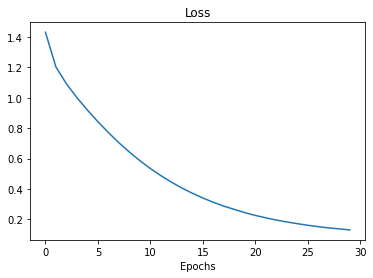

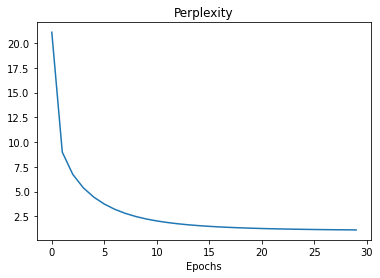

In [59]:
plot_metrics(cache)

# Inference Mode
Now, it's time to try the model and ask him a few questins :)

Helper function: to clean the text the user has entered.

In [0]:
def clean_text(text):
    """
    This method takes a string, applies different text preprocessing 
    (characters replacement, removal of unwanted characters, removal of extra 
    whitespaces) operations and returns a string.
    Arguments:
      text: a string.
    Returns:
      a cleaned version of text.
    """
    
    import re
    
    text = str(text)
    
    # REPLACEMENT
    text = re.sub('\"', '\'', text)
    text = re.sub("“", '\'', text)
    text = re.sub("”", '\'', text)
    text = re.sub('’', '\'', text)
    text = re.sub('\[','(', text)
    text = re.sub('\]',')', text)
    text = re.sub('\{','(', text)
    text = re.sub('\}',')', text)
    text = re.sub("([?.!,:;'?!+\-*/=%$@&()])", r" \1 ", text)

    pattern = re.compile('[^a-zA-Z0-9_\.\,\:\;\'\?\!\+\-\*\/\=\%\$\@\&\(\)]')
    # remove unwanted characters
    text = re.sub(pattern, ' ', text)
    
    # lower case the characters in the string
    text = text.lower()
    
    # REMOVAL OF EXTRA WHITESPACES
    # remove duplicated spaces
    text = re.sub(' +', ' ', text)
    # remove leading and trailing spaces
    text = text.strip()
    
    return text

The following fucntion passes a sentence that has been entered by the user to the model and returns its answer along with the input.



In [0]:
def evaluate(sentence):
    """
    This function takes a sentence (question) and returns the model's output
    (answer) to it.
    Arguemnts:
      sentence: a string.
    Returns:
      result: a string, representing model's output to the input.
      sentence: a string, the input sentence.
    """

    # clean the input sentence (question) to prepare for the encoder
    sentence = clean_text(sentence)
    sentence = '<start> ' + sentence + ' <end>'

    # tokenize the input sentence and pad zeros if its length is less than
    # maximum sequence length.
    inputs = [text_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # initilize the hidden state of the encoder
    enc_hidden = (tf.zeros((1, units)), 
                  tf.zeros((1, units)), 
                  tf.zeros((1, units)), 
                  tf.zeros((1, units)))
    
    enc_output, enc_hidden, enc_c = encoder(inputs, enc_hidden)
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([text_tokenizer.word_index['<start>']], 0)
    
    # generate answer, where the maximum length for the answer is equal
    # to max_length_targ=32
    for t in range(max_length_targ):
      predictions, dec_hidden, attention_weights = decoder(dec_input, 
                                                          dec_hidden, 
                                                          enc_output)

      predicted_id = tf.argmax(predictions[0]).numpy()
      result += text_tokenizer.index_word[predicted_id] + ' '

      if text_tokenizer.index_word[predicted_id] == '<end>':
        return result, sentence

      # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [0]:
def answer(sentence):
  """
  This function takes an input sentence by the user and prints the 
  model's answer along with the user's input sentence.
  Arguments:
      sentence: a string.
  """

  result, sentence = evaluate(sentence)

  print(f'INPUT: {sentence}')
  print(f'CHATBOT ANSWER: {result}')

Let's try to talk to the chatbot:



In [63]:
answer('tell me something funny')


INPUT: <start> tell me something funny <end>
CHATBOT ANSWER: think of the other hand , but the other monster says , at least a boy i ' ve had to nail them put in old joke . <end> 


In [64]:
answer('What is it that you want in life?')


INPUT: <start> what is it that you want in life ? <end>
CHATBOT ANSWER: me : a third door . 2 : oh , we ' <end> 


In [65]:
answer("you're so fun")


INPUT: <start> you ' re so fun <end>
CHATBOT ANSWER: you ' re a puppy . <end> 


In [66]:
answer("do you like annoying people?")


INPUT: <start> do you like annoying people ? <end>
CHATBOT ANSWER: because i ' m a pain in the bathroom and hold the stuff in the bathroom and hold the stuff in the bathroom and hold the stuff in the bathroom and hold 


In [67]:
answer('are you my friend?')


INPUT: <start> are you my friend ? <end>
CHATBOT ANSWER: because your stories ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! 


In [68]:
answer("what is your favorite movie?")


INPUT: <start> what is your favorite movie ? <end>
CHATBOT ANSWER: she ' s not god : and it ' s a well earthquake in sucking . <end> 


In [69]:
answer("how do you sleep at night?")


INPUT: <start> how do you sleep at night ? <end>
CHATBOT ANSWER: i carry your homework , mostly . <end> 


In [70]:
answer("what will happen if you went inside a black hole?")


INPUT: <start> what will happen if you went inside a black hole ? <end>
CHATBOT ANSWER: i don ' t know either . it must be out of your waitress . <end> 


In [71]:
answer('If we count sheep to fall asleep, what do they count?')


INPUT: <start> if we count sheep to fall asleep , what do they count ? <end>
CHATBOT ANSWER: would , eggs <end> 


In [72]:
answer("Why do people order double cheese burgers, large fries, and a diet coke?")


INPUT: <start> why do people order double cheese burgers , large fries , and a diet coke ? <end>
CHATBOT ANSWER: because the shits don ' t like there , but they like . <end> 


In [73]:
answer("What is always coming, but never arrives?")


INPUT: <start> what is always coming , but never arrives ? <end>
CHATBOT ANSWER: <end> 


In [74]:
answer("who is the most stupid person you know?")


INPUT: <start> who is the most stupid person you know ? <end>
CHATBOT ANSWER: and . who is left ? <end> 


In [75]:
answer("knock knock")


INPUT: <start> knock knock <end>
CHATBOT ANSWER: who ' s there ? . who ? is between us . <end> 


In [76]:
answer("tell me a joke")


INPUT: <start> tell me a joke <end>
CHATBOT ANSWER: think - ' <end> 


In [77]:
answer("Do you exercise?")


INPUT: <start> do you exercise ? <end>
CHATBOT ANSWER: because i put a coffee shop . me : hey , i am ! <end> 


In [78]:
answer("How do you keep a clear mind during hard times?")


INPUT: <start> how do you keep a clear mind during hard times ? <end>
CHATBOT ANSWER: give him a bus <end> 


In [79]:
answer("who is your best friend?")


INPUT: <start> who is your best friend ? <end>
CHATBOT ANSWER: robert ' ' yesterday . ' <end> 


In [80]:
answer("what do you have in mind?")


INPUT: <start> what do you have in mind ? <end>
CHATBOT ANSWER: me : struggling , for me : ' my backpack ? me : ' my friend told me the bartender , for the tape ! ' <end> 


In [81]:
answer("who is you favorite singer?")

INPUT: <start> who is you favorite singer ? <end>
CHATBOT ANSWER: <end> 


In [82]:
answer("Are you enjoying this conversation?")

INPUT: <start> are you enjoying this conversation ? <end>
CHATBOT ANSWER: because you ' re 10 / 10 <end> 


In [83]:
answer("Do you know Google assistant?")


INPUT: <start> do you know google assistant ? <end>
CHATBOT ANSWER: i ' ve never let you a mean that has a mean that has a mean that has a mean that has a mean that has a mean that has a mean 


In [84]:
answer("what do you like to talk about the most?")


INPUT: <start> what do you like to talk about the most ? <end>
CHATBOT ANSWER: go for granite . <end> 


In [85]:
answer("Why do you like to talk about fire?")


INPUT: <start> why do you like to talk about fire ? <end>
CHATBOT ANSWER: me : you ' re already taken . <end> 


In [86]:
answer("What was the best thing before sliced bread?")


INPUT: <start> what was the best thing before sliced bread ? <end>
CHATBOT ANSWER: massive sandwiches <end> 


In [87]:
answer("What is better than the FOUNTAIN OF YOUTH?")


INPUT: <start> what is better than the fountain of youth ? <end>
CHATBOT ANSWER: going to . <end> 


In [88]:
answer("Are you lazy?")


INPUT: <start> are you lazy ? <end>
CHATBOT ANSWER: because i ' m a bitch . <end> 


In [89]:
answer("How do you know that you'll never quit smoking?")


INPUT: <start> how do you know that you ' ll never quit smoking ? <end>
CHATBOT ANSWER: when the fuck are you . <end> 


In [90]:
answer("When will you quit smoking?")


INPUT: <start> when will you quit smoking ? <end>
CHATBOT ANSWER: i just wrote three . <end> 


In [91]:
answer("Who talks the most?")


INPUT: <start> who talks the most ? <end>
CHATBOT ANSWER: when the s 9 / 11 9 year old son says the one for the girl , the one is always in a way . <end> 


In [92]:
answer("Who lies the most?")


INPUT: <start> who lies the most ? <end>
CHATBOT ANSWER: a very big spider with a car with a car with a car with a car with a car with a car with a car with a car with a car with 


In [93]:
answer("What do you know about computers?")


INPUT: <start> what do you know about computers ? <end>
CHATBOT ANSWER: you ' re not that you have to share this one . <end> 


In [94]:
answer("Where do like to travel?")


INPUT: <start> where do like to travel ? <end>
CHATBOT ANSWER: in a . <end> 


In [95]:
answer("Which country do you want to visit?")


INPUT: <start> which country do you want to visit ? <end>
CHATBOT ANSWER: the song is the big metal . <end> 


In [96]:
answer("Which type of music do you like?")


INPUT: <start> which type of music do you like ? <end>
CHATBOT ANSWER: i ' m a big metal fan , i ' m a big metal fan , i ' m a big metal fan , i ' m a big metal fan , 


In [97]:
answer("what's your job?")


INPUT: <start> what ' s your job ? <end>
CHATBOT ANSWER: patient : mailman dr dog : * him * i don ' t give a crane . . . <end> 


In [98]:
answer("Are you an artificial intelligence model?")


INPUT: <start> are you an artificial intelligence model ? <end>
CHATBOT ANSWER: an ass is over here . <end> 


In [99]:
answer("How are you doing?")


INPUT: <start> how are you doing ? <end>
CHATBOT ANSWER: me : * starts to respond but i shove my arm off her : word . <end> 


In [100]:
answer("How are you?")


INPUT: <start> how are you ? <end>
CHATBOT ANSWER: not good , maria . clearly . <end> 


In [101]:
answer("How was your day?")


INPUT: <start> how was your day ? <end>
CHATBOT ANSWER: you know , i thought ' ' . <end> 


In [102]:
answer("Where do you vacation?")


INPUT: <start> where do you vacation ? <end>
CHATBOT ANSWER: the . home . <end> 


In [103]:
answer("Thanks for your time.")


INPUT: <start> thanks for your time . <end>
CHATBOT ANSWER: that means a gun . ) <end> 


In [104]:
answer("What is your least favorite food?")


INPUT: <start> what is your least favorite food ? <end>
CHATBOT ANSWER: your boat <end> 


In [105]:
answer("What is the most hilarious childhood memory you can think of?")


INPUT: <start> what is the most hilarious childhood memory you can think of ? <end>
CHATBOT ANSWER: person with the most states the people called the people called the people called the people called the people called the people called the people called the people called the people called 


In [106]:
answer("Are you funny?")


INPUT: <start> are you funny ? <end>
CHATBOT ANSWER: no i ' m not laugh . <end> 


In [107]:
answer("Beethoven or Bach?")


INPUT: <start> beethoven or bach ? <end>
CHATBOT ANSWER: how do we got one . <end> 


In [108]:
answer("How do you like your coffee?")


INPUT: <start> how do you like your coffee ? <end>
CHATBOT ANSWER: you go to cry because it was a week or mine . <end> 


In [109]:
answer("What is your favorite sport?")


INPUT: <start> what is your favorite sport ? <end>
CHATBOT ANSWER: <end> 


In [110]:
answer("What is your favorite car?")


INPUT: <start> what is your favorite car ? <end>
CHATBOT ANSWER: the . <end> 


Start a conversation with the chatbot:

The following function takes an input sentence from the user and prints the model's answer to it until the user enters exit() to finish the conversation:

In [0]:
def chat():
    """
    This function takes input from the user and outputs the chatbot's answer
    until the user inputs `exit()`
    """

    print("Start your conversation with the chatbot!")
    print("If you want to end this conversation, enter: exit()\nHave fun!")  

    while True:
      # take user input
      user_input = str(input('>>'))
      
      if user_input == 'exit()':
        break

      try:
        # generate an answer for the user's question.
        chatbot_answer, _ = evaluate(user_input)
        print(chatbot_answer)
      except:
        # in case there's word out of chatbot vocabulary.
        print("Oops! can't help you there! Try different words or restructure your sentence.")

In [112]:
chat()


Start your conversation with the chatbot!
If you want to end this conversation, enter: exit()
Have fun!
>>Are you a man or a woman?
because i want to c ' t we going to * * t - man - er she seems like a girl ' s best friend how to go in it <end> 
>>Are you a chat bot?
Oops! can't help you there! Try different words or restructure your sentence.
>>How do you plan for vacations?
Oops! can't help you there! Try different words or restructure your sentence.
>>How do you plan for holidays?
it first google maps . <end> 
>>bye
that ' s there are like a car <end> 
>>exit()


As we notice, not all the answers generated by the model are good or valid answers and there's a lot to improve here. For example, there's some answers with repeated blocks of words. Also, some of the answers are not valid responses to the questions and do not relate the topic being proposed in the question. This kind of performance is expected for a deep learning chatbot with this very small dataset but it's okay for a demo project which can be improved.

# What can we do to improve performance:
**More data**: if we want to have good performance with somewhat impressive responses, we need to train on a lot more data, maybe millions of pairs. However, training on a large scale dataset requires more computational power (maybe a more powerful GPU) and a more sophisticated model with more layers and units, let alone finding and acquiring such dataset.

**DISCLAIMER**: the model has been trained on 175,671 question-answer pairs which have been gathered from different sources like reddit, and it turns out that some of the model's answers are impolite, just something to be aware of.

## References:
 - Effective Approaches to Attention-based Neural Machine Translation

  - Neural machine translation with attention

  - Neural Machine Translation by Jointly Learning to Align and Translate

   - Neural Machine Translation (seq2seq) Tutorial